## This notebook is used to deploy the linear discreate inverse problems

#### 导入依赖包

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import block_diag
import ff
import vis
import regula

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

#### Construct the 3D density model and then obtain kernal function and gravity response.

In [2]:
shape = (8, 8, 8) #nz ny-EW nx-SN
area = (0, 1600, 0, 1600, 200, 1000) #NS EW Down
nshape = (16, 16) 
narea = (-400, 2000, -400, 2000) #NS, EW
density=np.zeros(shape)
    
nz = shape[0]
ny = shape[1]
nx = shape[2]
    
density[: , : , : ] = 0.001
i = 0; j = 0; k = 0
for i in range(3):
    density[ i+1, 2*i:2*i+3, 3:5] = 1
    #density[ 1, 7 : 16, :] = 0.8

ncell = nz*ny*nx     
    #global kernel kernal:核矩阵， gob s:重力观测值， depth:深度信息
kernel, gobs, depthz = ff.greenmat(shape = shape, nshape = nshape, density = density,
                            area = area, narea = narea, noisefree = True)

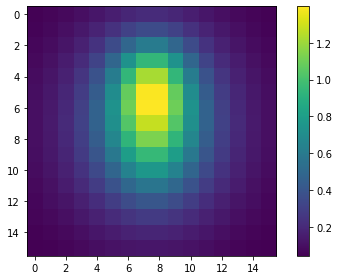

In [3]:
plt.imshow(gobs.reshape(nshape).T)
plt.colorbar()
plt.tight_layout()

### The Gauss-Newton solution solution of the model parameters that minimizes the least-squares misfit
$$ F\left(m \right)=\frac{1}{2} \sum_{i=1}^N \left(d_i-g_i\left(m\right) \right)^2 $$
$$ m_{est}=\left( G^TG \right)^{-1}G^Td $$


In [4]:
print("Kernal shape:", kernel.shape)
print("G_obs shape:", gobs.shape)

m_lse1 = np.linalg.pinv(np.dot(kernel.T, kernel))
print("m_lse1 shape:", m_lse1.shape)
m_lse2 = np.dot(np.dot(m_lse1, kernel.T), gobs)
print("m_lse2 shape:", m_lse2.shape)
res_lse = np.array(m_lse2).reshape(8, 8, 8)
print("Result shape:", res_lse.shape)
predict = np.mat(kernel)*np.transpose(np.mat(res_lse.ravel()))

Kernal shape: (256, 512)
G_obs shape: (256, 1)
m_lse1 shape: (512, 512)
m_lse2 shape: (512, 1)
Result shape: (8, 8, 8)


In [5]:
m_lse1

array([[ 2.90934200e+08,  8.18217358e+08,  8.45309494e+08, ...,
         2.30101739e+09, -1.20345705e+09,  9.14940871e+08],
       [ 8.11769228e+08,  2.94813437e+09,  4.77374491e+09, ...,
         7.57534383e+09, -7.80354524e+09,  4.28283617e+09],
       [ 9.17394440e+08,  5.02400077e+09,  1.29182282e+10, ...,
         1.42583865e+10, -1.77201957e+10,  9.75924614e+09],
       ...,
       [ 2.60494941e+08,  1.30993009e+09,  4.82393070e+09, ...,
         2.45299822e+11, -1.84444631e+11, -9.15809425e+10],
       [ 1.51402347e+06, -4.13217288e+09, -1.23846350e+10, ...,
        -1.82725873e+11,  1.25803725e+12,  5.41335089e+10],
       [-2.83162687e+08,  5.91000392e+08,  4.55594505e+09, ...,
        -1.00245862e+11,  5.70076030e+10,  3.03127623e+11]])

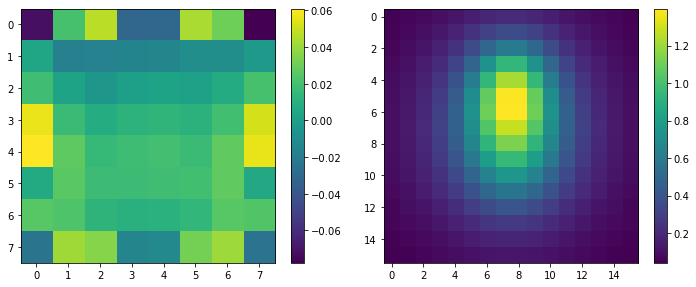

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(res_lse[7, :, :])
plt.colorbar()
plt.subplot(122)
plt.imshow(predict.reshape(nshape).T)
plt.colorbar()
plt.tight_layout()

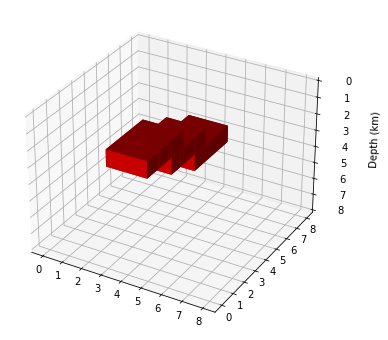

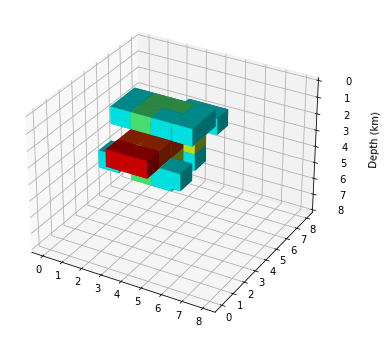

In [7]:
vis.Model(density, 0.4, filename = '1')
vis.Model(res_lse, 0.4, filename = '1')

### The Gauss-Newton solution solution of the model parameters that minimizes the least-squares misfit(With data variance on the diagonal)
$$ F\left(m \right)=\frac{1}{2} \sum_{i=1}^N \left(d_i-g_i\left(m\right) \right)^2 $$
$$ m_{est}=\left( G^T C_d^{-1} G \right)^{-1}G^T C_d^{-1} d $$

In [8]:
Cd = np.eye(gobs.shape[0])/0.0001
print("Cd shape:", Cd.shape)
Cd_inv = np.linalg.pinv(Cd)
print("Cd_inv shape:", Cd_inv.shape)
print("Kernal shape:", kernel.shape)
print("G_obs shape:", gobs.shape)

m_lse1 = np.linalg.pinv(np.dot(np.dot(kernel.T, Cd_inv), kernel))
print("m_lse1 shape:", m_lse1.shape)
m_lse2 = np.dot(np.dot(np.dot(m_lse1, kernel.T), Cd_inv), gobs)
print("m_lse2 shape:", m_lse2.shape)
res_lse = np.array(m_lse2).reshape(8, 8, 8)
print("Result shape:", res_lse.shape)
predict = np.mat(kernel)*np.transpose(np.mat(res_lse.ravel()))

Cd shape: (256, 256)
Cd_inv shape: (256, 256)
Kernal shape: (256, 512)
G_obs shape: (256, 1)
m_lse1 shape: (512, 512)
m_lse2 shape: (512, 1)
Result shape: (8, 8, 8)


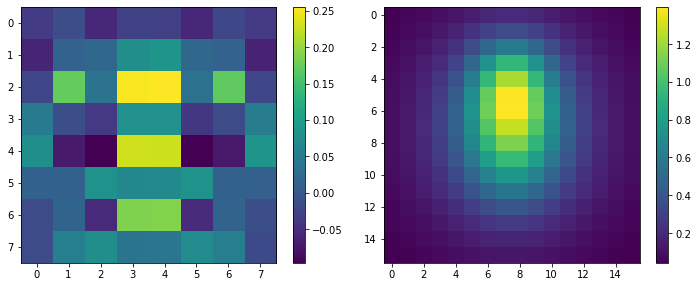

In [9]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(res_lse[3, :, :])
plt.colorbar()
plt.subplot(122)
plt.imshow(predict.reshape(nshape).T)
plt.colorbar()
plt.tight_layout()

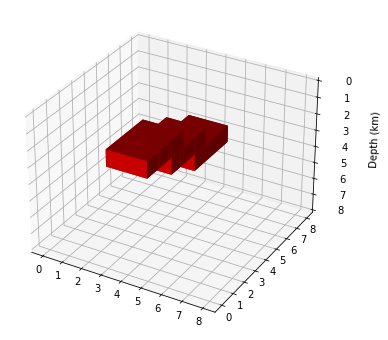

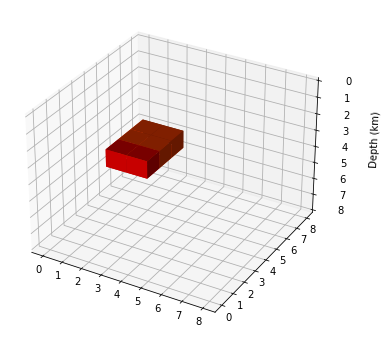

In [10]:
vis.Model(density, 0.4, filename = '1')
vis.Model(res_lse, 0.7, filename = '1')

### The Gauss-Newton solution solution of the model parameters that minimizes the least-squares misfit(With Smooth constraints)
$$ F\left(m \right)=\frac{1}{2} \left(d-Gm\right)^T C_d^{-1} \left(d-Gm\right) + \lambda^2  \left(Lm \right)^T  \left( Lm\right)$$
where $\mu_p$ is the expected value of that model based on our prior information
$$ m_{est}=\left( G^T C_d^{-1} G +\lambda^2 L^T L\right)^{-1} G^T C_d^{-1} d $$
for 3D inversion problem:
$$ m_{est}=\left( G^T C_d^{-1} G  +\alpha^2 L_x^T L_x+ \beta^2 L_y^T L_y+ \zeta^2 L_z^T L_z\right)^{-1} G^T C_d^{-1} d $$

In [11]:
#构建光滑项
Lx = regula.Lx(shape)
print("Lx shape:", Lx.shape)
Ly = regula.Ly(shape)
print("Ly shape:", Ly.shape)
Lz = regula.Lz(shape)
print("Ly shape:", Lz.shape)
# x方向一阶光滑强度
alpha = 0.1
# y方向一阶光滑强度
beta = 0.1
# z方向一阶光滑强度
zeta = 0.1
# 数据可信度
Cd_c = 1

norm = alpha*np.dot(Lx.T, Lx) + beta*np.dot(Ly.T, Ly) + zeta*np.dot(Lz.T, Lz)

Cd = np.eye(gobs.shape[0])/Cd_c
print("Cd shape:", Cd.shape)
Cd_inv = np.linalg.pinv(Cd)
print("Cd_inv shape:", Cd_inv.shape)
print("Kernal shape:", kernel.shape)
print("G_obs shape:", gobs.shape)

m_lse1 = np.linalg.pinv(np.dot(np.dot(kernel.T, Cd_inv), kernel) + norm)
print("m_lse1 shape:", m_lse1.shape)
m_lse2 = np.dot(np.dot(np.dot(m_lse1, kernel.T), Cd_inv), gobs)
print("m_lse2 shape:", m_lse2.shape)
res_lse = np.array(m_lse2).reshape(8, 8, 8)
print("Result shape:", res_lse.shape)
predict = np.mat(kernel)*np.transpose(np.mat(res_lse.ravel()))

Lx shape: (448, 512)
Ly shape: (448, 512)
Ly shape: (448, 512)
Cd shape: (256, 256)
Cd_inv shape: (256, 256)
Kernal shape: (256, 512)
G_obs shape: (256, 1)
m_lse1 shape: (512, 512)
m_lse2 shape: (512, 1)
Result shape: (8, 8, 8)


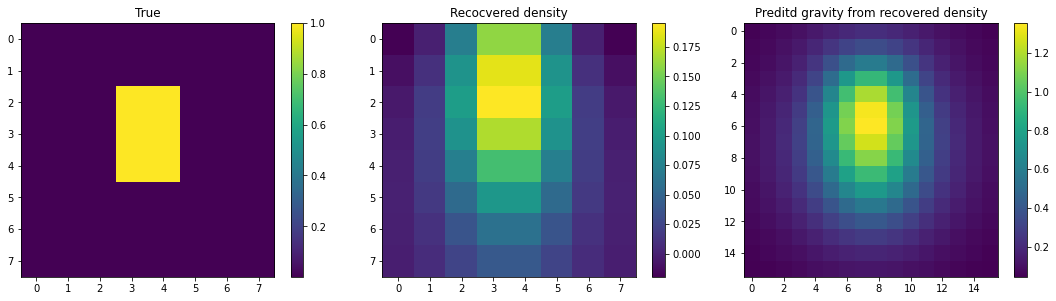

In [12]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(density[2, :, :])
plt.title("True")
plt.colorbar()
plt.subplot(132)
plt.imshow(res_lse[2, :, :])
plt.title("Recocvered density")
plt.colorbar()
plt.subplot(133)
plt.imshow(predict.reshape(nshape).T)
plt.title("Preditd gravity from recovered density")
plt.colorbar()
plt.tight_layout()

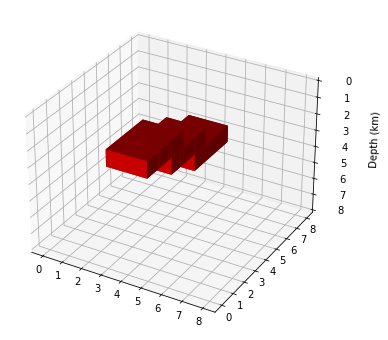

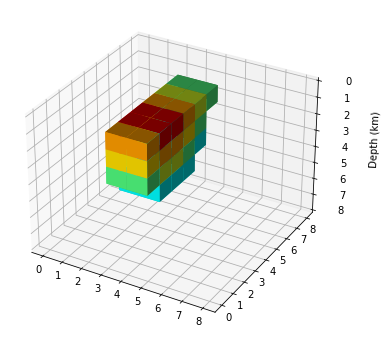

In [13]:
vis.Model(density, 0.4, filename = '1')
vis.Model(res_lse, 0.4, filename = '1')

### The Gauss-Newton solution solution of the model parameters that minimizes the least-squares misfit(With data variance, reference model and smooth constraints)
$$ F\left(m \right)=\frac{1}{2} \left(d-Gm\right)^T C_d^{-1} \left(d-Gm\right) + \alpha^2\left(Lm\right)^T\left(Lm\right) +\frac{1}{2} \left(\mu_p-m\right)^T C_p^{-1} \left(\mu_p-_m\right)$$
where $\mu_p$ is the expected value of that model based on our prior information
$$ m_{est}=\left( G^T C_d^{-1} G + \alpha^2 L_x^T L_x+ \beta^2 L_y^T L_y+ \zeta^2 L_z^T L_z + C_p^{-1}\right)^{-1} \left(G^T C_d^{-1} d + C_p^{-1} \mu_p \right)$$
where $C_p^{-1}=\delta W_m^2$ and $C_d^{-1}=\lambda W_d^{2}$ (In this scenario, $W_m^{2}=I$ and $W_d^{2}=I$)

In [14]:
#手动调参版
#构建光滑项
Lx = regula.Lx(shape)
print("Lx shape:", Lx.shape)
Ly = regula.Ly(shape)
print("Ly shape:", Ly.shape)
Lz = regula.Lz(shape)
print("Ly shape:", Lz.shape)

# x方向一阶光滑强度
alpha = 0.01
# y方向一阶光滑强度
beta = 0.01
# z方向一阶光滑强度
zeta = 0.01
# 数据可信度
Cd_c = 0.1
# 模型可信度
Cp_c = 0.1

norm = alpha*np.dot(Lx.T, Lx) + beta*np.dot(Ly.T, Ly) + zeta*np.dot(Lz.T, Lz)

## 定义参考模型
Cd = np.eye(gobs.shape[0])/Cd_c
print("Cd shape:", Cd.shape)
Cd_inv = np.linalg.pinv(Cd)
print("Cd_inv shape:", Cd_inv.shape)

ref_density = density.ravel()
ref_density = ref_density.reshape(512, 1)
Cp = np.eye(512)/Cp_c
Cp_inv = np.linalg.pinv(Cp)

print("Cp_inv shape:", Cp_inv.shape)
print("Ref density shape:", ref_density.shape)
print("Kernal shape:", kernel.shape)
print("G_obs shape:", gobs.shape)

m_lse1 = np.linalg.pinv(np.dot(np.dot(kernel.T, Cd_inv), kernel) + Cp_inv + norm)
print("m_lse1 shape:", m_lse1.shape)
m_lse2 = np.dot(np.dot(kernel.T, Cd_inv), gobs) + np.dot(Cp_inv, ref_density)
print("m_lse2 shape:", m_lse2.shape)
result = np.dot(m_lse1, m_lse2)
res_lse = np.array(result).reshape(8, 8, 8)
print("Result shape:", res_lse.shape)
predict = np.mat(kernel)*np.transpose(np.mat(res_lse.ravel()))

Lx shape: (448, 512)
Ly shape: (448, 512)
Ly shape: (448, 512)
Cd shape: (256, 256)
Cd_inv shape: (256, 256)
Cp_inv shape: (512, 512)
Ref density shape: (512, 1)
Kernal shape: (256, 512)
G_obs shape: (256, 1)
m_lse1 shape: (512, 512)
m_lse2 shape: (512, 1)
Result shape: (8, 8, 8)


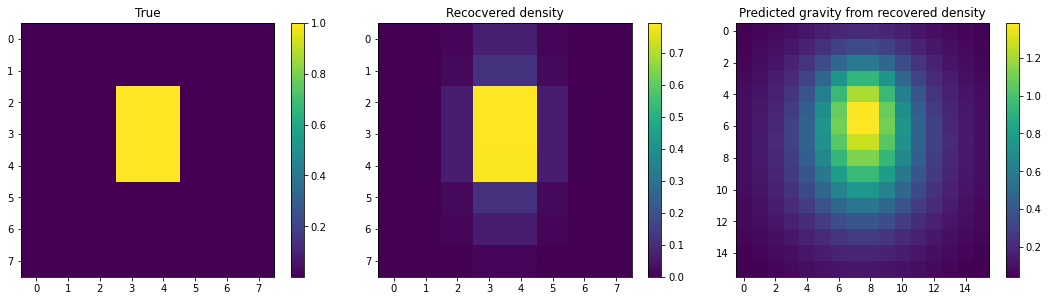

In [15]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(density[2, :, :])
plt.title("True")
plt.colorbar()
plt.subplot(132)
plt.imshow(res_lse[2, :, :])
plt.title("Recocvered density")
plt.colorbar()
plt.subplot(133)
plt.imshow(predict.reshape(nshape).T)
plt.title("Predicted gravity from recovered density")
plt.colorbar()
plt.tight_layout()

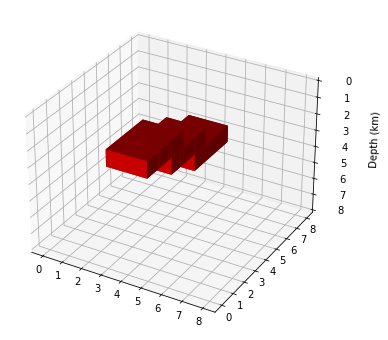

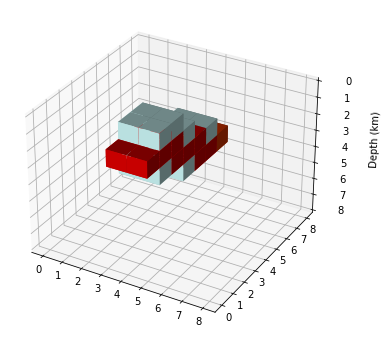

In [16]:
vis.Model(density, 0.4, filename = '1')
vis.Model(res_lse, 0.1, filename = '1')